# Aim

Create both atmospheric turbulence and vibrations at once!

In [1]:
# imports and setup

# I have hcipy as a submodule, so this import may vary
import sys
sys.path.append("..")
from hcipy.hcipy import *

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats, signal, optimize

from aberrations import *

In [2]:
tt_cms = make_atm_data()

Text(0.5, 1.0, 'Atmospheric tip-tilts')

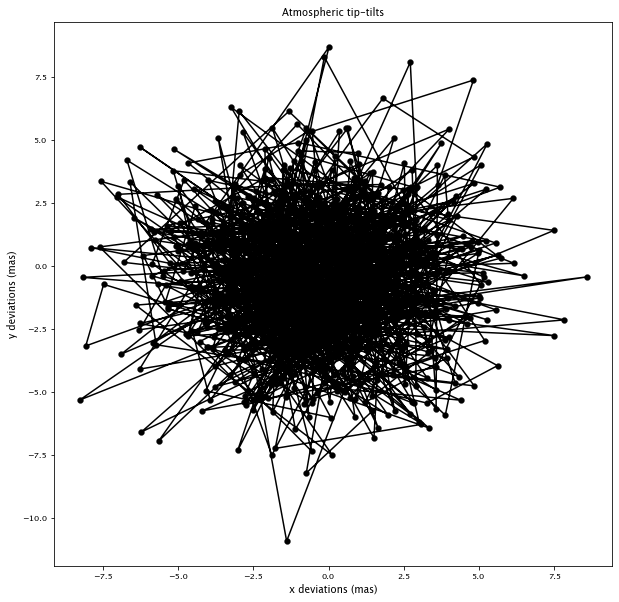

In [3]:
plt.figure(figsize=(10,10))
plt.plot(tt_cms[:,0], tt_cms[:,1], 'ko-')
plt.xlabel("x deviations (mas)")
plt.ylabel("y deviations (mas)")
plt.title("Atmospheric tip-tilts")

In [9]:
vibe_aberrations = make_2D_vibe_data()
combined = make_noisy_data(tt_cms.T + vibe_aberrations)

ValueError: operands could not be broadcast together with shapes (2,1000) (2000,) 

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(vibe_aberrations[:,0], vibe_aberrations[:,1], 'ko-')
plt.xlabel("x deviations (mas)")
plt.ylabel("y deviations (mas)")
plt.title("Vibration tip-tilts")

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(combined[:,0], combined[:,1], 'ko-')
plt.xlabel("x deviations (mas)")
plt.ylabel("y deviations (mas)")
plt.title("Full tip-tilts")

In [ ]:
# plotting the PSD of just one dimension, expecting an f^-2 power law
plt.figure(figsize=(10,10))
freqs, psd = signal.periodogram(combined[:,0], f_sampling)
log_freqs, log_power = np.log(freqs[1:]), np.log(psd[1:])
m, b, _, _, _ = stats.linregress(log_freqs, log_power)

def plot_powerlaw(aberration, description):
    freqs, psd = signal.periodogram(aberration, f_sampling)
    log_freqs, log_power = np.log(freqs[1:]), np.log(psd[1:])
    m, b = stats.linregress(log_freqs, log_power)[:2]
    print(description + " m =", m)
    plt.semilogy(freqs, psd, label='Actual (' + description + ')')
    plt.semilogy(freqs[1:], np.exp(b) * freqs[1:]**m, label='Fit (' + description + ')')
    plt.ylim(1e-7)
    plt.legend()
    
plot_powerlaw(tt_cms[:,0], "turbulence")
plot_powerlaw(combined[:,0], "combined")

In [ ]:
ind = np.argmax(freqs > f_w)
assert ind != 0, "didn't find a high enough frequency"
avg_measurement_power = np.mean(psd[ind:])
measurement_noise_recovered = np.sqrt(f_sampling * avg_measurement_power)
print(measurement_noise_recovered)

In [ ]:
vibe_only_psd = signal.periodogram(combined[:,0], f_sampling)[1] - signal.periodogram(tt_cms[:,0], f_sampling)[1]
plt.figure(figsize=(10,10))
plt.semilogy(freqs, vibe_only_psd)
plt.semilogy(*signal.periodogram(vibe_aberrations[:,0], f_sampling))
plt.ylim(1e-7)

In [ ]:
def smoothen(psd):
    c = 0.1
    # a pretty trivial smoothening procedure
    for i, p in enumerate(psd):
        if p <= 0:
            if 0 < i < len(psd)-1:
                psd[i] = c * psd[i-1] + c * psd[i+1]
            elif i == 0:
                psd[i] = 2 * c * psd[i+1]
            else:
                psd[i] = 2 * c * psd[i-1]
    return psd

plt.figure(figsize=(10,10))
plt.semilogy(freqs, smoothen(vibe_only_psd))
plt.semilogy(*signal.periodogram(vibe_aberrations[:,0], f_sampling))
plt.ylim(1e-7)